In [1]:
import numpy as np
from scipy.integrate import solve_ivp

from simulator import OrbitSimulator
from plotting import *
import constants as const


def generate_reference_trajectory_numerical(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:
    def keplerian_rhs(t, s):
        r, v = s[:3], s[3:]
        a = -const.MU_EARTH / np.linalg.norm(r)**3 * r
        return np.hstack([v, a])
    times = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(fun=keplerian_rhs, t_span=t_span, y0=s0, t_eval=times, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y.T

def generate_reference_trajectory(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:

    s0 = np.linalg.norm(s0)
    w = np.sqrt(const.MU_EARTH / s0**3)
    t_range = np.arange(t_span[0], t_span[1], dt)

    x = s0 * np.cos(w * t_range)
    y = s0 * np.sin(w * t_range)
    vx = -s0 * w * np.sin(w * t_range)
    vy = s0 * w * np.cos(w * t_range)

    results = np.column_stack([x, y, np.zeros_like(x), vx, vy, np.zeros_like(x)])

    return t_range, results


In [2]:
def run_full_simulation():
    print("--- Running Final Simulation with PD Controller (with Deadband) ---")
    
    # 1. Define Simulation Parameters
    duration_days = 1  # Changed from 2 to 3 days
    t_span = (0, duration_days * 24 * 3600)
    dt = 1.0

    # 2. Define the "True" Model Parameters with the new gamma
    # Updated values from your last message
    true_satellite_params = {'C_R': 1.5, 'A': 20.0, 'm': 1000.0}
    
    # New policy parameters from the notebook
    true_policy_params = {
        'gamma': 5000,        # 5 km deadband radius
        'Kp': 5e-12,          # Proportional gain from the notebook
        'Kd': 1e-9           # Derivative gain from the notebook
    }

    true_sigma = 0.0

    # 3. Generate Reference Trajectory
    print("Generating ideal Keplerian reference trajectory...")
    ref_times, ref_states = generate_reference_trajectory(const.S0, t_span, dt)
    
    # 4. Initialize and Run Simulator
    print("Initializing full simulator with 'true' parameters...")
    full_simulator = OrbitSimulator(
        satellite_params=true_satellite_params,
        policy_params=true_policy_params,
        sigma=true_sigma
    )
    
    print("Running simulation... (this may take a moment)")
    # UNPACK THE NEW RETURN VALUE: control_actions
    # full_simulator.simulate(const.S0, t_span, dt, ref_states)
    full_simulator.simulate_SLV(const.S0, t_span, dt, ref_states)


    df = full_simulator.get_log()

    
    print("Simulation complete.")


    plot2d(df)
    plot3d(df)
    plot_acceleration_components(log_df=df)
    # plot_controller_performance(log_df=df, policy_params=true_policy_params)
    plot_control_acceleration(log_df=df)
    plot_position_error(log_df=df, policy_params=true_policy_params)


    return df

--- Running Final Simulation with PD Controller (with Deadband) ---
Generating ideal Keplerian reference trajectory...
Initializing full simulator with 'true' parameters...
Running simulation... (this may take a moment)
Precomputing ephemeris data...
Simulation complete.


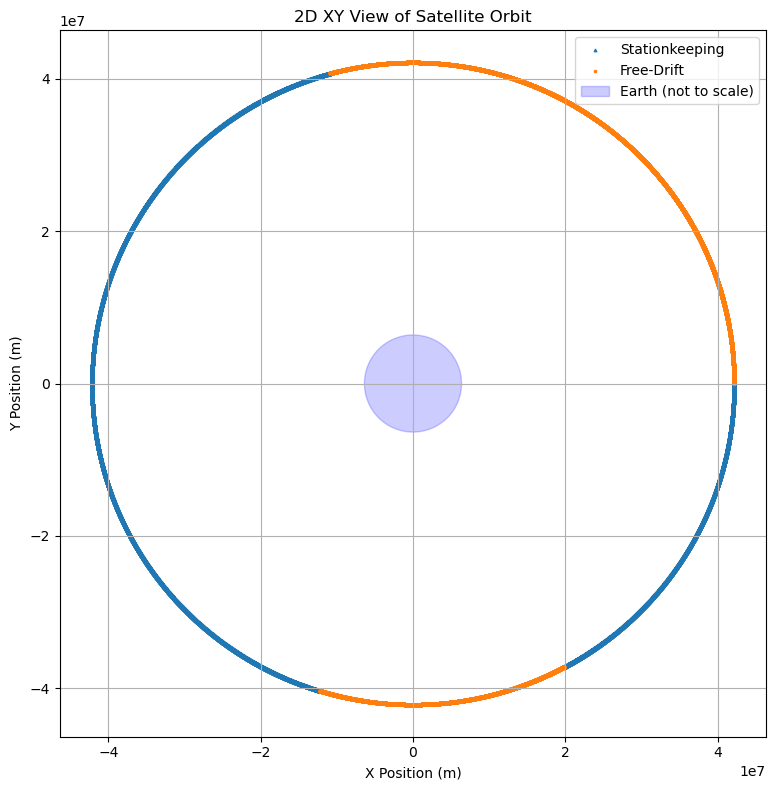

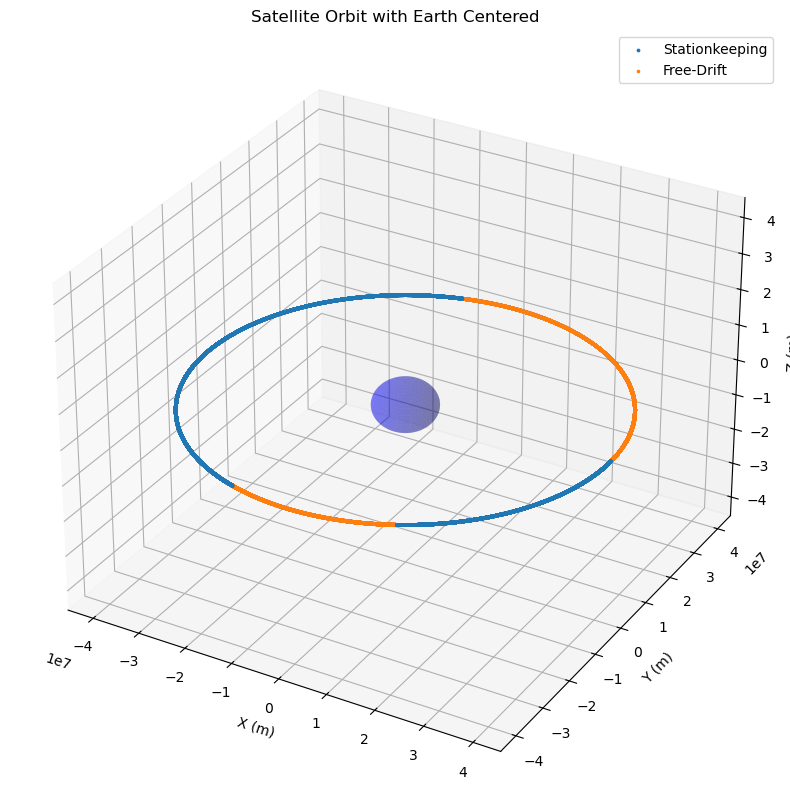

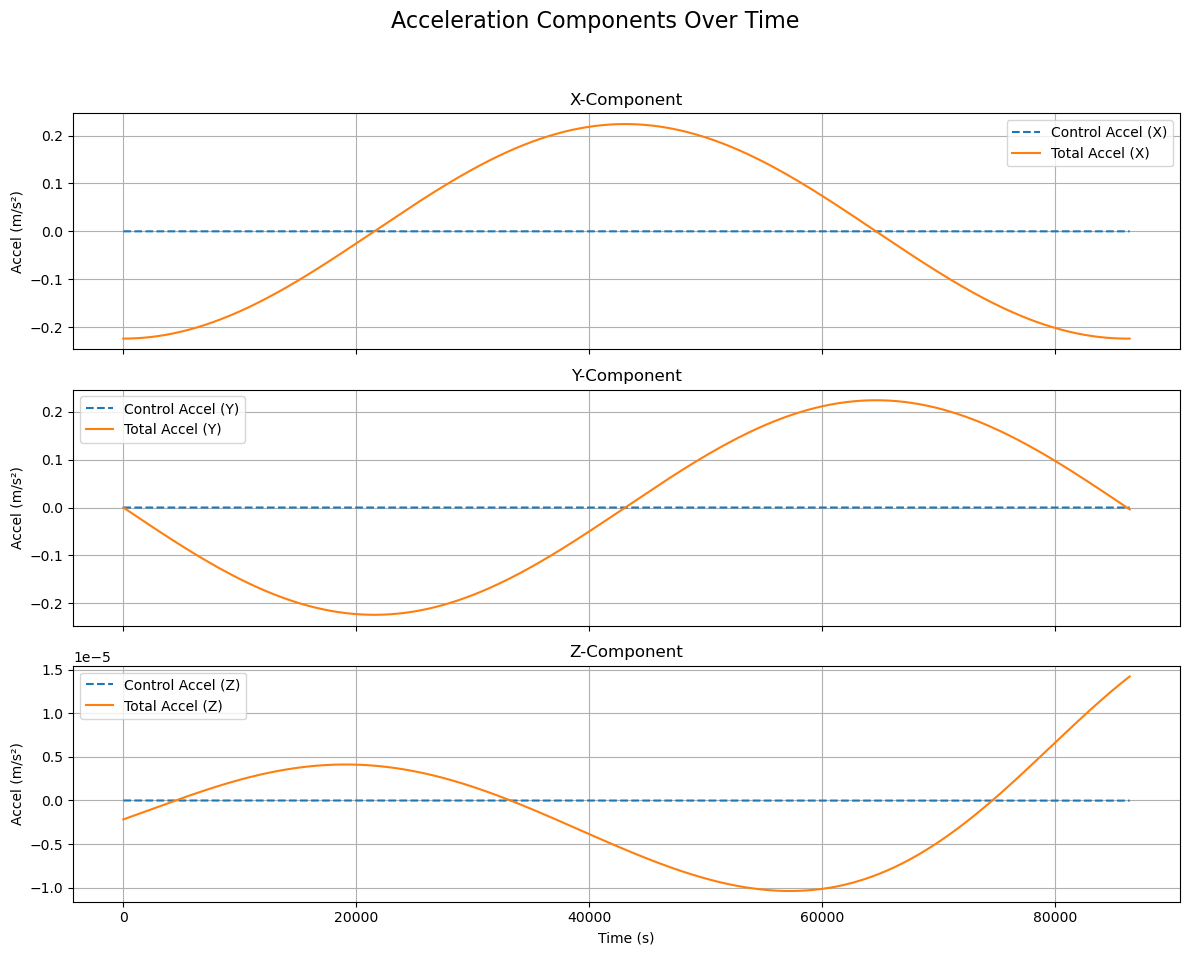

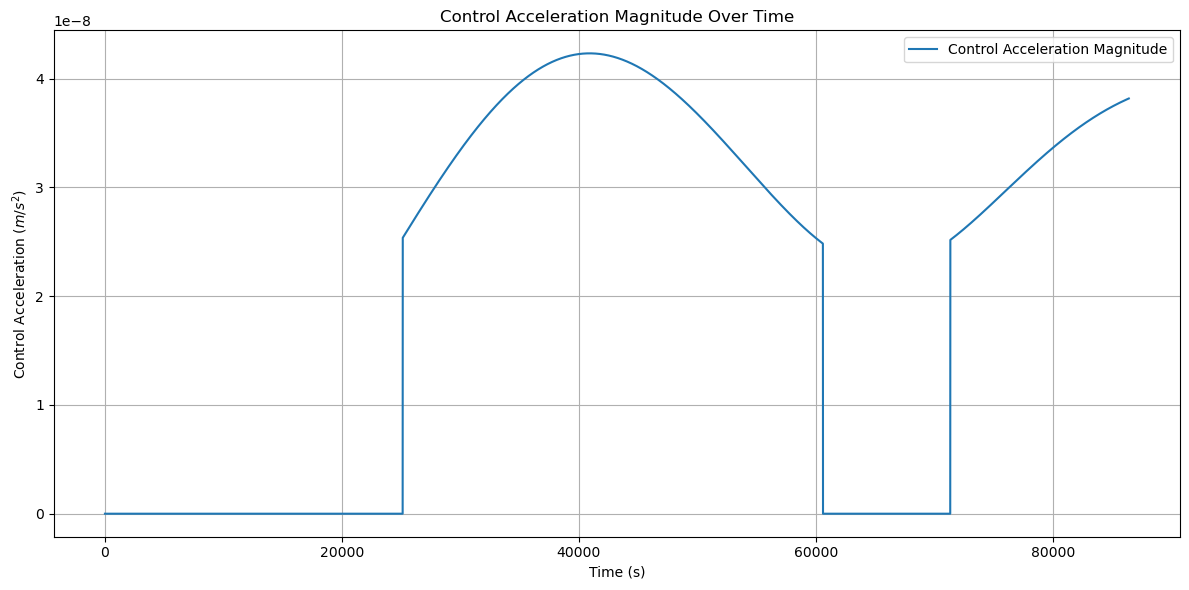

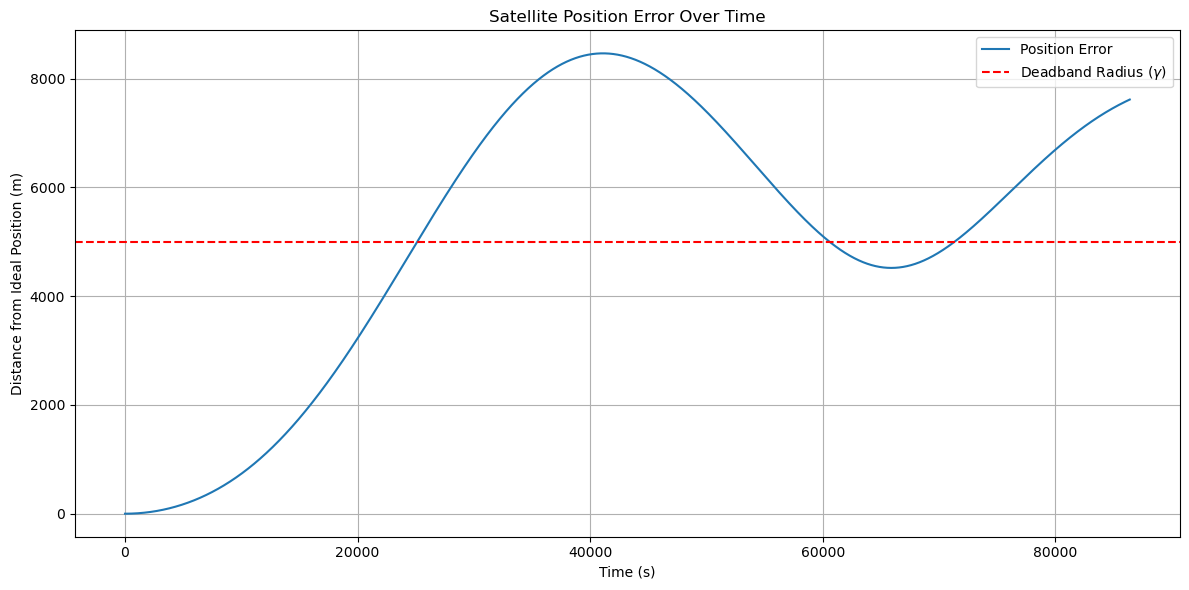

In [3]:
df = run_full_simulation()